Variables of filenames

In [13]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/cbm/ML/JupyterNotebooks/'
signalFileName = directory + 'PlainTree_20kSign.root'
backgroundFileName = directory + 'PlainTree_5kBckgr.root'

# Cuts Optimization using Extra Gradient Boosting


Over the last years, **Machine Learning** tools have been successfully applied to problems in high-energy physics. For example, for the classification of physics objects. Supervised machine learning algorithms allow for significant improvements in classification problems by taking into account observable correlations and by learning the optimal selection from examples, e.g. from Monte Carlo simulations.


# Importing the Libraries

**Numpy** is a powerful library that makes working with python more efficient, so we will import it and use it as np in the code. **Pandas** is another useful library that is built on numpy and has two great objects *series* and *dataframework*. Pandas works great for *data ingestion* and also has *data visualization* features. From **Hipe4ml** we import **TreeHandler** and with the help of this function we will import our *Analysis Tree* to our notebook.

**Matplotlib** comes handy in plotting data while the machine learning is performed by **XGBOOST**. We will import data splitter from **Scikit-learn** as *train_test_split*. **Evaluation metrics** such as *confusion matrix*, *Receiver operating characteristic (ROC)*, and *Area Under the Receiver Operating Characteristic Curve (ROC AUC)*  will be used to asses our models.

In [14]:
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install

fatal: destination path 'CBM_ML_Lambda_Library' already exists and is not an empty directory.
/Users/julnow/gsi/cbm/ML/JupyterNotebooks/CBM_ML_Lambda_Library/CBM_ML_Lambda_Library
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
From https://github.com/shahidzk1/CBM_ML_Lambda_Library
 * branch            main       -> FETCH_HEAD
Already up to date.
running install
running bdist_egg
running egg_info
writi

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from CBM_ML import tree_importer,  KFPF_lambda_cuts, plot_tools
from bayes_opt import BayesianOptimization

import gc

# Importing the data
CBM has a modified version of the cern's root software and it contains the simulated setup of CBM. Normally, a model generated input file is passed through different macros. These macros represent the CBM setup and it is like taking particles and passing them through a detector. These particles are registered as hits in the setup. Then particles' tracks are reconstructed from these hits using cellular automaton and Kalman Filter mathematics.


CBM uses the **tree** format of cern root to store information. To reduce the size of these root files a modified tree file was created by the name of Analysis tree. This Analysis tree file contains most of the information that we need for physics analysis. 

Lambda $(\Lambda)$ is the most abundant strange baryon produced at FAIR energies. It weakly decays, with a branching ratio of $64 \%$, into a proton and a negatively charged pion ($\pi^-$). To reconstruct $\Lambda$ all proton and $\pi^-$ tracks are combined to make its invariant mass spectrum.

In this example, we download three files that were converted to flat TTree format (simplest structure to be read by Python). The first one was generated with DCM-QGSM-SMM generator, passed through Geant4 with $p_{beam}$ = 12A Gev/c and minimum bias configuration, contains mostly signal candidates of $\Lambda$ i.e. it contains protons and $\pi^-$ which come from a $\Lambda$ decay. The second one contains all proton and $\pi^-$ 10k pairs in a 100 k events data set, generated by using URQMD generator with with $p_{beam}$ = 12A Gev/c and minimum bias configuration. The third one also contains 100 k events data set, generated by using DCM-QGSM-SMM generator with with $p_{beam}$ = 12A Gev/c and minimum bias configuration.



The above data frame object has some columns/features and for them at the very last column (issignal) the true Monte Carlos information is available. This MC information tells us whether this reconstructed particle was originally produced as a decaying particle or not. So a value of 1 means that it is a true candidate and 0 means that it is not.

# Selecting Background and Signal
We have selected signal candidates only from the DCM model, therefore, we are treating it as simulated data. The URQMD data set will be treated as real experimental data.

Our URQMD 100k events data, which looks more like what we will get from the final experiment, has a lot more background than signal. This problem of unequal ratio of classes (signal and background) in our data set (URQMD, 99.99% background and less than 1% signal) is called imbalance classification problem. 

One of the solutions to tackle this problem is resampling the data. Deleting instances from the over-represented class (in our case the background), under-sampling, is a resampling method. 

So for training and testing we will get signal candidates from the DCM signal and  background from URQMD (3 times signal size).

In [16]:
#CUTS FOR MASS SELECTION
#5 sigma region for signal
lower5SigmaCutSign = 0.43485
upper5SigmaCutSign = 0.56135
#mean invariant mass
invMass = 0.4981
# "5sigma" (not acutal 5 sigma) region for background
lower5SigmaCutBckgr = 0.1
upper5SigmaCutBckgr = 2

In [17]:
# We import three root files into our jupyter notebook
#sign - before cleaning but after 5sigma seletion, signal - cleaned
#so that we dont have to reimport everything with each change
sign = tree_importer.tree_importer(signalFileName,'PlainTree',7)

# We only select lambda candidates in the 5 sigma region around the kaon mass peak
#we preserve the cleaned dataframe with a changed name
sign = sign[(sign['Candidates_generation']==1) & (sign['Candidates_mass']>lower5SigmaCutSign) & (sign['Candidates_mass']<upper5SigmaCutSign)]

# Similarly for the background, we select background candidates which are not in the 5 sigma region of the kaon peak
bckgr = tree_importer.tree_importer(backgroundFileName,'PlainTree',7)
#we preserve the cleaned dataframe with a changed name
bckgr = bckgr[(bckgr['Candidates_generation'] < 1)
                 & ((bckgr['Candidates_mass'] > lower5SigmaCutBckgr)
                 & (bckgr['Candidates_mass'] < lower5SigmaCutSign) | (bckgr['Candidates_mass']>upper5SigmaCutSign) 
                    & (bckgr['Candidates_mass'] < upper5SigmaCutBckgr))].sample(n=3*(sign.shape[0]))

#Also call the garbage collector of python to collect unused items to free memory
gc.collect()

2506

In [18]:
#we remove name prefixes 'Candidates'
bckgr.columns = bckgr.columns.str.replace('Candidates_', '')
bckgr.columns = bckgr.columns.str.replace('_', '')
sign.columns = sign.columns.str.replace('Candidates_', '')
sign.columns = sign.columns.str.replace('_', '')
#we also get rid of coordinates errors
sign = sign.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr']).rename(columns={'generation' : 'issignal'})
bckgr = bckgr.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr']).rename(columns={'generation' : 'issignal'})
#let's check the name prefixes 
sign.iloc[0:10,:]

,chi2geo,chi2primfirst,chi2primsecond,chi2topo,cosinefirst,cosinesecond,cosinetopo,distance,eta,l,...,pT,phi,px,py,pz,rapidity,x,y,z,issignal
0,1.891688,1.962368e+06,3.017848e+06,0.938048,0.990561,0.924455,1.000000,0.013951,2.486938,7.397236,...,0.269387,-1.558258,0.003378,-0.269366,1.608406,1.766340,-0.051667,-1.166708,7.296682,1.0
1,7.539669,3.927906e+03,2.038832e+05,103.285400,0.985466,0.928299,0.998588,0.022819,2.094620,1.386346,...,0.373378,0.968337,0.211583,0.307643,1.493373,1.604629,0.376725,0.412234,1.773447,1.0
2,1.706541,7.728520e+03,4.239785e+02,0.606264,0.955050,0.999384,1.000000,0.030017,2.734314,1.283027,...,0.291869,-1.159367,0.116724,-0.267513,2.237798,2.062438,0.119157,-0.202402,1.272765,1.0
4,2.070187,2.158610e+07,4.508973e+06,1.449760,0.976016,0.987120,0.999998,0.003052,2.068460,10.053052,...,0.521730,-1.788829,-0.112855,-0.509378,2.031160,1.767285,-0.482202,-2.512969,9.732567,1.0
5,0.537335,1.793734e+05,1.617219e+05,3.097740,0.987572,0.995492,0.999998,0.029134,3.090779,32.053776,...,0.302186,2.902284,-0.293574,0.071627,3.316302,2.436012,-2.803859,0.580953,31.920332,1.0
6,0.257597,5.342024e+05,9.920105e+05,0.969224,0.925308,0.996354,0.999998,0.005320,1.954566,13.186787,...,0.524860,-3.008992,-0.520253,-0.069393,1.815813,1.649541,-3.583114,-0.511573,12.667512,1.0
7,2.127710,3.653666e+03,9.920105e+05,6.588306,0.925887,0.996342,0.999930,0.586026,1.961199,12.109749,...,0.521093,-3.003699,-0.516146,-0.071628,1.815266,1.650730,-3.338621,-0.394638,11.621171,1.0
8,0.103044,8.387899e+06,1.482735e+06,0.227272,0.933116,0.941300,0.999997,0.012125,3.510073,5.652082,...,0.066963,-0.268308,0.064567,-0.017752,1.119001,1.534259,0.373925,-0.139267,5.640086,1.0
9,0.023616,1.803456e+05,6.524398e+04,0.616352,0.984480,0.992189,0.999999,0.001906,3.053359,3.185786,...,0.260483,-0.457327,0.233715,-0.115017,2.753188,2.287027,0.310549,-0.140175,3.170335,1.0
10,0.077631,2.429541e+00,5.637176e-01,0.353259,0.979226,0.999809,0.999806,0.007593,1.471561,0.156857,...,1.095867,2.672994,-0.977734,0.494934,2.261026,1.386728,-0.021697,0.022588,0.140684,1.0


# Data Cleaning
Sometimes a data set contains entries which are outliers or does not make sense. For example, infinite values or NaN entries. We clean the data by removing these entries. 

Similarly, CBM is a fixed target experiment so there are certain conditions which the data has to satisfy before it is considered as reliable data.So we apply certain limits on the data sets.

The values of these cuts are described: https://drive.google.com/file/d/1tb0FBRq4KgVu-VQZgpjA8ONbIGVCNOnE/view?usp=sharing https://github.com/julnow/JupyterNotebooks/blob/kaon/CBM%20K-short%20data%20cleaning.pdf

In [19]:
#CUTS USED FOR DATA CLEANING
#mass cuts for both bckgr and sign
lowerMassCut = 0.279
upperMassCut = 1.5
#distance cuts
#DCA
lowerDcaCut = 0
upperDcaCut = 100
#l distance
lowerLCut = 0
upperLCut = 80
#loverdl
lowerLdlCut = 0
upperLdlCut = 5000
#coordinate cuts
absXCut = 50
absYCut = 50
lowerZCut = 0
upperZCut = 80
#momentums cuts
pzLowerCut = 0
pUpperCut = 20
ptUpperCut = 3
#chi2
#geo
lowerChi2GeoCut = 0
upperChi2GeoCut = 1000
#topo
lowerChi2TopoCut = 0
upperChi2TopoCut = 100000
#prim first
lowerChi2PrimFirstCut = 0
upperChi2PrimFirstCut = 3e7
#prim second
lowerChi2PrimSecondCut = 0
upperChi2PrimSecondCut = 3e7
#pseudorapidity cuts
lowerEtaCut = 1.5
upperEtaCut = 3.82

In [21]:
def clean_df(df):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    is_good_mom = (df['pz'] > pzLowerCut) & (df['p']<pUpperCut) & (df['pT']<ptUpperCut)
    is_good_coord = (abs(df['x']) < absXCut) & (abs(df['y']) < absYCut) & (df['z']>lowerZCut) & (df['z']<upperZCut)
    is_good_params = (df['distance'] > lowerDcaCut) & (df['distance'] < upperDcaCut) & (df['chi2geo']>lowerChi2GeoCut) & (df['chi2geo'] < upperChi2GeoCut) & (df['chi2topo'] > lowerChi2TopoCut) & (df['chi2topo'] < upperChi2TopoCut) & (df['eta']>lowerEtaCut) & (df['eta']<upperEtaCut)& (df['l']>lowerLCut) & (df['l']<upperLCut) & (df['loverdl']>lowerLdlCut) & (df['loverdl']<upperLdlCut)
    is_good_daughters = (df['chi2primfirst']>lowerChi2PrimFirstCut) & (df['chi2primfirst'] < upperChi2PrimSecondCut) & (df['chi2primsecond']>lowerChi2PrimSecondCut) & (df['chi2primsecond']<upperChi2PrimFirstCut)
    is_good_mass = (df['mass']>lowerMassCut) & (df['mass']<upperMassCut)

    is_good_df = (is_good_mom) & (is_good_coord) & (is_good_params) & (is_good_daughters) & (is_good_mass)

    return df[is_good_df]

In [22]:
background = clean_df(bckgr)
signal = clean_df(sign)
del sign, bckgr

In [23]:
#Let's combine signal and background
df_scaled = pd.concat([signal, background])
# Let's shuffle the rows randomly
df_scaled = df_scaled.sample(frac=1)

In [26]:
#lets draw sign to background ratio
def plt_sig_back(df):
    range1 = (lowerMassCut, upperMassCut)
    fig, axs = plt.subplots(figsize=(10, 6))
    #df_scaled['mass'].plot.hist(bins = 300, range=range1,grid=True,sharey=True)
    (df[df['issignal']==0])['mass'].plot.hist(bins = 300, facecolor='yellow',grid=True,range=range1, label='Background')
    (df[df['issignal']==1])['mass'].plot.hist(bins = 300, facecolor='magenta',grid=True, range=range1, label ='Signal')
    #plt.vlines(x=1.108,ymin=-1,ymax=48000, color='black', linestyle='-')
    #plt.vlines(x=1.1227,ymin=-1,ymax=48000, color='black', linestyle='-')
    plt.ylabel("Counts (log scale)", fontsize=15)
    plt.xlabel("Mass in GeV/$c^2$", fontsize= 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.title('Test and Train Lambda Invariant Mass', fontsize = 15)
    plt.legend( fontsize = 15)
    axs.tick_params(axis='both', which='major', labelsize=18)
    plt.yscale("log")
    fig.tight_layout()
    #fig.savefig("hists.png")

3896

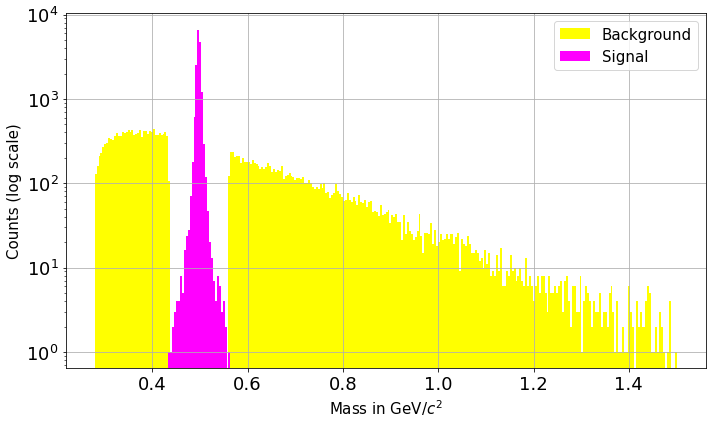

In [27]:
plt_sig_back(df_scaled)
gc.collect()

# Creating Train and Test sets
To make machine learning algorithms more efficient on unseen data we divide our data into two sets. One set is for training the algorithm and the other is for testing the algorithm. If we don't do this then the algorithm can overfit and we will not capture the general trends in the data. 

In [28]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
cuts = [ 'loverdl', 'distance', 'chi2geo', 'chi2topo', 'chi2primfirst', 'chi2primsecond']


x = df_scaled[cuts].copy()

# The MC information is saved in this y variable
y =pd.DataFrame(df_scaled['issignal'], dtype='int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=324)

#DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. 
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest=xgb.DMatrix(x_test, label = y_test)

## Bayesian optimization
In order to find the best parameters of XGB for our data we use Bayesian optimization. Grid search and and random search could also do the same job but bayesian is more time efficient. For further reading visit [the git page](https://github.com/fmfn/BayesianOptimization) of the bayesian optimization used here.

### Hyper parameters
Some of the following hyper parameters will be tuned for our algorithm:


*subsample* [default=1]
Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
range: (0,1]

*eta* [default=0.3, alias: learning_rate]
Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
range: [0,1]


*gamma* [default=0, alias: min_split_loss]
Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
range: [0,∞]


*alpha* [default=0, alias: reg_alpha]
L1 regularization term on weights. Increasing this value will make model more conservative.

*Lasso Regression* (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

In [29]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, alpha, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'n_estimators': n_estimators,
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.3,
              'eval_metric': 'auc', 'nthread' : 7}
    cv_result = xgb.cv(params, dtrain, num_boost_round=10, nfold=5)
    return  cv_result['test-auc-mean'].iloc[-1]

In [30]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 10),
                                             'gamma': (0, 1),
                                            'alpha': (2,20),
                                             'learning_rate':(0,1),
                                             'n_estimators':(100,500)
                                            })

In [31]:
#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5)

|   iter    |  target   |   alpha   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
[10:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[10:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[10:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[10:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[10:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[10:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[10:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[10:36:28] src/tree/updater_prune.cc:74: tre

# XGB models
Now let's take the parameters selected by the bayesian optimization and apply them in our training and testing. 

In [32]:
max_param = xgb_bo.max['params']
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'learning_rate': max_param['learning_rate'], 'max_depth': int(round(max_param['max_depth'],0)), 'n_estimators': int(round(max_param['n_estimators'],0)), 'objective': 'reg:logistic'}
gc.collect()

44999

In [33]:
#To train the algorithm using the parameters selected by bayesian optimization
#Fit/train on training data
bst = xgb.train(param, dtrain)

#predicitions on training set
bst_train= pd.DataFrame(data=bst.predict(dtrain, output_margin=False),  columns=["xgb_preds"])
y_train=y_train.set_index(np.arange(0,bst_train.shape[0]))
bst_train['issignal']=y_train['issignal']

[10:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[10:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[10:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[10:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[10:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[10:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_

In [34]:
#predictions on test set
bst_test = pd.DataFrame(data=bst.predict(dtest, output_margin=False),  columns=["xgb_preds"])
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
bst_test['issignal']=y_test['issignal']

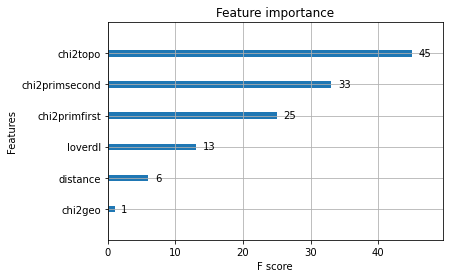

In [35]:
#The following graph will show us that which features are important for the model
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()
ax.figure.tight_layout() 
#ax.figure.savefig("hits.png")

## AUC and ROC

The function roc_curve computes the receiver operating characteristic curve, or ROC curve. Quoting Wikipedia :

“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

This function requires the true binary value and the target scores, which can either be probability estimates of the positive class, confidence values, or binary decisions.

Similarly, the function roc_auc_score computes Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

To find the best threshold which results more signal to background ratio for lambda candidates we use the parameter the approximate median significance by the higgs boson  ML challenge (http://higgsml.lal.in2p3.fr/documentation,9.)

/Users/julnow/gsi/cbm/ML/JupyterNotebooks/CBM_ML_Lambda_Library/CBM_ML/plot_tools.py:19: RuntimeWarning: divide by zero encountered in true_divide
  S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
/Users/julnow/gsi/cbm/ML/JupyterNotebooks/CBM_ML_Lambda_Library/CBM_ML/plot_tools.py:19: RuntimeWarning: invalid value encountered in true_divide
  S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
/Users/julnow/gsi/cbm/ML/JupyterNotebooks/CBM_ML_Lambda_Library/CBM_ML/plot_tools.py:26: RuntimeWarning: divide by zero encountered in true_divide
  S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))
/Users/julnow/gsi/cbm/ML/JupyterNotebooks/CBM_ML_Lambda_Library/CBM_ML/plot_tools.py:26: RuntimeWarning: invalid value encountered in true_divide
  S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))


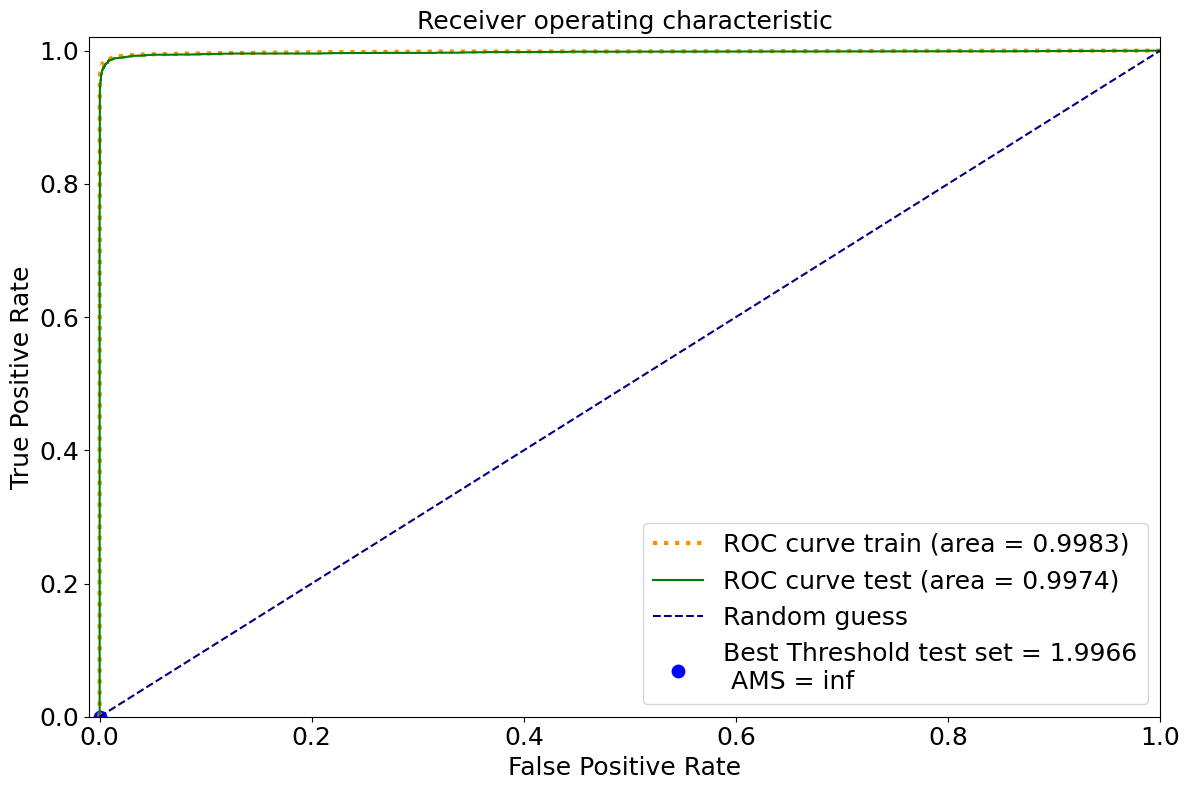

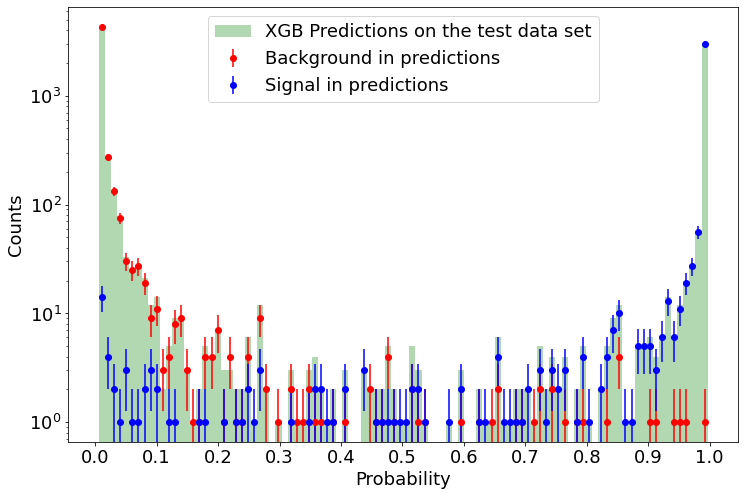

In [36]:
#ROC cures for the predictions on train and test sets
train_best, test_best = plot_tools.AMS(y_train, bst_train['xgb_preds'],y_test, bst_test['xgb_preds'])

#The first argument should be a data frame, the second a column in it, in the form 'preds'
plot_tools.preds_prob(bst_test,'xgb_preds', 'issignal','test')

When the AUC, best threshold and approximate median significance for train and test are nearly the same, we save that model and use it. This means that our model is general enough. In my opinion, if the test S0 is above 3.0 then it is a good enough model.

In [37]:
#To save some memory on colab we delete some unused variables
del dtrain, dtest, x_train, x_test, y_train, y_test, df_scaled
gc.collect()

22046

## Confusion Matrix

A **Confusion Matrix** $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus in binary classification, the count of true positives is $C_{00}$, false negatives $C_{01}$,false positives is $C_{10}$, and true neagtives is $C_{11}$.

If $ y^{'}_{i} $ is the predicted value of the $ i$-th sample and $y_{i}$ is the corresponding true value, then the fraction of correct predictions over $ n_{samples}$ is defined as 
$$
True \: positives (y,y^{'}) =  \sum_{i=1}^{n_{samples} } 1 (y^{'}_{i} = y_{i}=1)
$$ 

The following function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.

In [38]:
#lets take the best threshold and look at the confusion matrix
cut1 = test_best
df_dcm['xgb_preds1'] = ((df_dcm['xgb_preds']>cut1)*1)
cnf_matrix = confusion_matrix(df_dcm['issignal'], df_dcm['xgb_preds1'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_tools.plot_confusion_matrix(cnf_matrix, classes=['signal','background'], title='Confusion Matrix for XGB for cut > '+str(cut1))
#plt.savefig('confusion_matrix_extreme_gradient_boosting_whole_data.png')

NameError: name 'df_dcm' is not defined

In [ ]:
plot_tools.cut_visualization(df_urqmd,'xgb_preds',test_best)

## Tree visualization

In [ ]:
xgb.to_graphviz(bst, fmap='', num_trees=0, rankdir=None, yes_color=None, no_color=None, condition_node_params=None, leaf_node_params=None)

# Comparison with the manually optimized cuts of KFPF
In the already existing Kalman Filter Particle Finder (KFPF) package for online reconstruction and selection of short-lived particles in CBM, these criteria have been manually optimized. These selection-cuts have been selected to maximize the signal to background ratio (S/B) of the $\Lambda$ for a certain energy on a collisions generator. The selection criteria mainly depends on the collision energy, decay channel and detector configuration.

In [ ]:
new_check_set= df_urqmd.copy()
new_check_set['new_signal']=0
mask1 = (new_check_set['chi2primpos'] > 18.4) & (new_check_set['chi2primneg'] > 18.4)

mask2 = (new_check_set['ldl'] > 5) & (new_check_set['distance'] < 1)

mask3 = (new_check_set['chi2geo'] < 3) 

new_check_set = new_check_set[(mask1) & (mask2) & (mask3)] 

#After all these cuts, what is left is considered as signal, so we replace all the values in the 'new_signal'
# column by 1
new_check_set['new_signal'] = 1
cnf_matrix = confusion_matrix(new_check_set['issignal'], new_check_set['new_signal'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_tools.plot_confusion_matrix(cnf_matrix, classes=['signal','background'], title='Confusion Matrix for KFPF')

In [ ]:
cut3 = test_best
mask1 = df_original['xgb_preds']>cut3
df3=df_original[mask1]

In [ ]:
plot_tools.comaprison_XGB_KFPF(df3['mass'],new_check_set['mass'])

In [ ]:
del x,y,x_test,y_test,x_whole,y_whole,dtest,dtrain,dtest1,df3,df_clean,df_scaled
gc.collect()

In [ ]:
input_tree = uproot.open('/content/drive/MyDrive/10k_events_dcmqgsm.root:PlainTree').arrays(library='np')
gc.collect()

In [ ]:
df_original= pd.DataFrame(data=input_tree)
del input_tree
gc.collect()

# Importing the final predictor to root
We will use the treelite library to transport the final predictor of our model to root

In [ ]:
#install treelite 
!pip install treelite
import treelite
#create an object out of your model, bst in our case
model = treelite.Model.from_xgboost(bst)
#use GCC compiler
toolchain = 'gcc'
#parallel_comp can be changed upto as many processors as one have
model.export_lib(toolchain=toolchain, libpath='./mymodel.so',
                 params={'parallel_comp': 8}, verbose=True)

# Operating system of the target machine
platform = 'unix'
# C compiler to use to compile prediction code on the target machine
toolchain = 'gcc'
# Save the source package as a zip archive named mymodel.zip
# Later, we'll use this package to produce the library mymodel.so.
model.export_srcpkg(platform=platform, toolchain=toolchain,
                    pkgpath='./mymodel.zip', libname='mymodel.so',
                    verbose=True)

In [ ]:
!unzip mymodel.zip

In [ ]:
#Build the source package (using GNU Make or NMake).
%cd mymodel 
!make

!ls

If one wants to transfer this model to a different computer, target machine, then one should follow the following commands in command prompt

In [ ]:
sftp john@lxpool.gsi.de
sftp> put mymodel.zip
sftp> quit

In [ ]:
ssh john@lxpool.gsi.de
unzip mymodel.zip
cd mymodel
make -j8



The following C++ code can be the applied as a macro on some new data file

In [ ]:
%%writefile test.cpp
#include "TROOT.h"
#include "TFile.h"
#include "TTree.h"
#include "TH1F.h"
#include <vector>
#include "TString.h"
#include "TMath.h"
#include "TH1.h"
#include "TF1.h"
#include "TCanvas.h"

#include <stdio.h>
#include <stdlib.h>
#include "main.c"

void python_to_root(){
  TCanvas* c1 = new TCanvas();
  //c1->Divide(2,1);
  //c1->cd(1);
  
  /* Open the root file*/
  TFile *f = new TFile("/gdrive/My Drive/presentations/treelite/10k_events_PFSimplePlainTree.root","UPDATE");
  TTree *t1 = (TTree*)f->Get("PlainTree");
  
  
  Float_t  LambdaCandidates_chi2primneg, LambdaCandidates_chi2primpos, LambdaCandidates_ldl, LambdaCandidates_distance, LambdaCandidates_chi2geo, LambdaCandidates_mass;
  
  t1->SetBranchAddress("LambdaCandidates_chi2primneg",&LambdaCandidates_chi2primneg);
  t1->SetBranchAddress("LambdaCandidates_chi2primpos",&LambdaCandidates_chi2primpos);
  t1->SetBranchAddress("LambdaCandidates_ldl",&LambdaCandidates_ldl);
  t1->SetBranchAddress("LambdaCandidates_distance",&LambdaCandidates_distance);
  t1->SetBranchAddress("LambdaCandidates_chi2geo",&LambdaCandidates_chi2geo);
  t1->SetBranchAddress("LambdaCandidates_mass",&LambdaCandidates_mass);
  
  
  std::vector<float> output{};
  
  const long n_entries = t1->GetEntries();
  output.reserve(n_entries);

  const size_t n_features = 5;
  union Entry input[n_features];
  
  //let's create a new branch which will store the probability returened for each proton-pion pair by our model 
  Float_t probab;
  TBranch *bpt = t1->Branch("probab",&probab,"probabilities");
  t1->SetBranchAddress("probab",&probab);
  
  TH1F *h = new TH1F("h_prob", "This is the #Lambda invariant mass after the cut >0.918080", 300, 1.04, 1.4);
  h->GetXaxis()->SetTitle("[GeV]");
  
  for (long i = 0; i < n_entries; i++)
   {
     t1->GetEntry(i);
    
    input[0].fvalue = LambdaCandidates_chi2primneg;
    input[1].fvalue = LambdaCandidates_chi2primpos;
    input[2].fvalue = LambdaCandidates_ldl;
    input[3].fvalue = LambdaCandidates_distance;
    input[4].fvalue = LambdaCandidates_chi2geo;
    
    output.push_back(predict(input, 0));
    probab= output.at(i);
   
    if(probab > 0.918080){
    h->Fill(LambdaCandidates_mass);}
  }
  
  h->Draw();

  
  
}


In [ ]:
# Installing root
!mkdir -p APPS
!pwd
!cd APPS && wget https://root.cern/download/root_v6.22.00.Linux-ubuntu19-x86_64-gcc9.2.tar.gz 
!cd APPS && tar -xf root_v6.22.00.Linux-ubuntu19-x86_64-gcc9.2.tar.gz

# Running colab on locally
https://research.google.com/colaboratory/local-runtimes.html